In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
#mounting the dataset from drive
# from google.colab import drive
# drive.mount('/content/gdrive') 

#connecting to sqlite db
con = sqlite3.connect('database.sqlite')
                      
# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
# Removing duplicate reviews
final=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final.shape)

(364173, 10)


In [7]:
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [10]:
#remove urls from text python
from tqdm import tqdm
lst = []
removed_urls_list = []
for text in tqdm(final['Text']):
  removed_urls_text = re.sub(r"http\S+", "", text)
  lst.append(removed_urls_text)

100%|██████████| 364171/364171 [00:00<00:00, 447313.57it/s]


In [11]:
#remove urls from text python
removed_urls_list = []
for text in tqdm(lst):
  removed_urls_text = re.sub(r"http\S+", "", text)
  removed_urls_list.append(removed_urls_text)

100%|██████████| 364171/364171 [00:00<00:00, 452270.97it/s]


In [12]:
from bs4 import BeautifulSoup
text_lst = []
for text in tqdm(removed_urls_list):
  soup = BeautifulSoup(text, 'lxml')
  text = soup.get_text()
  text_lst.append(text)
# print(text)
# print("="*50)

100%|██████████| 364171/364171 [01:49<00:00, 3330.00it/s]


In [13]:
print(len(final['Text']))

364171


In [14]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [15]:
decat_lst = []
for decat_text in tqdm(text_lst):
  text = decontracted(decat_text)
  decat_lst.append(text)

100%|██████████| 364171/364171 [00:05<00:00, 65510.16it/s]


In [16]:
strip_list = []
for to_strip in tqdm(decat_lst):
  text = re.sub("\S*\d\S*", "", to_strip).strip()
  strip_list.append(text)

100%|██████████| 364171/364171 [00:22<00:00, 16465.51it/s]


In [17]:
spatial_list = []
for to_spatial in tqdm(strip_list):
  text = re.sub('[^A-Za-z0-9]+', ' ', to_spatial)
  spatial_list.append(text)

100%|██████████| 364171/364171 [00:12<00:00, 29401.19it/s]


In [18]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [19]:
# Combining all the above stundents 
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(spatial_list):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [02:44<00:00, 2216.92it/s]


In [20]:
print(len(preprocessed_reviews))
preprocessed_reviews[-1]

364171


'satisfied product advertised use cereal raw vinegar general sweetner'

In [21]:
final['Preprocessed_text'] = preprocessed_reviews

In [22]:
print(len(final))
final.tail(5)

364171


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Preprocessed_text
525809,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,1,1299628800,Will not do without,Great for sesame chicken..this is a good if no...,great sesame chicken good not better resturant...
525810,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,0,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...,disappointed flavor chocolate notes especially...
525811,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,1,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",stars small give one training session tried tr...
525812,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,1,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...,best treats training rewarding dog good groomi...
525813,568454,B001LR2CU2,A3LGQPJCZVL9UC,srfell17,0,0,1,1338422400,Great Honey,"I am very satisfied ,product is as advertised,...",satisfied product advertised use cereal raw vi...


In [2]:
dir_path = os.getcwd()
conn = sqlite3.connect(os.path.join(dir_path, 'final.sqlite'))
# final.to_sql('Reviews', conn, if_exists='replace', index=False)

In [3]:
review_3 = pd.read_sql_query(""" SELECT count(*) FROM Reviews""", conn)
print(review_3)

   count(*)
0    364171


In [4]:
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews""", conn)

In [5]:
filtered_data.shape

(364171, 11)

In [6]:
filtered_data["Time"] = pd.to_datetime(filtered_data["Time"], unit = "s")
filtered_data = filtered_data.sort_values(by = "Time")

In [7]:
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Preprocessed_text
117924,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
117901,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...
298792,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuice well written movie everything exce...
169281,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captured film starring mic...
298791,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuice excellent funny movie keaton hilar...


In [8]:
print(len(filtered_data))
filtered_data.info()
filtered_data = filtered_data.head(100000)
print(len(filtered_data))

364171
<class 'pandas.core.frame.DataFrame'>
Int64Index: 364171 entries, 117924 to 107253
Data columns (total 11 columns):
Id                        364171 non-null int64
ProductId                 364171 non-null object
UserId                    364171 non-null object
ProfileName               364171 non-null object
HelpfulnessNumerator      364171 non-null int64
HelpfulnessDenominator    364171 non-null int64
Score                     364171 non-null int64
Time                      364171 non-null datetime64[ns]
Summary                   364171 non-null object
Text                      364171 non-null object
Preprocessed_text         364171 non-null object
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 33.3+ MB
100000


In [9]:
filtered_data['Score'].value_counts()

1    87729
0    12271
Name: Score, dtype: int64

In [10]:
X = filtered_data["Preprocessed_text"]
print(print("shape of X:", X.head(5)))
y = filtered_data["Score"]
print("shape of y:", y.head(5))

shape of X: 117924    witty little book makes son laugh loud recite ...
117901    remember seeing show aired television years ag...
298792    beetlejuice well written movie everything exce...
169281    twist rumplestiskin captured film starring mic...
298791    beetlejuice excellent funny movie keaton hilar...
Name: Preprocessed_text, dtype: object
None
shape of y: 117924    1
117901    1
298792    1
169281    1
298791    1
Name: Score, dtype: int64


In [11]:
from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)

In [12]:
print(X_train.shape, Y_train.shape, X_test.shape)
print(X_train.shape, Y_train.shape, X_val.shape)

(60000,) (60000,) (20000,)
(60000,) (60000,) (20000,)


# [4.1] BAG OF WORDS

In [13]:
from sklearn.feature_extraction.text import CountVectorizer 

count_vect = CountVectorizer()
X_train_vect = count_vect.fit_transform(X_train)
X_test_vect = count_vect.transform(X_test)
X_val_vect = count_vect.transform(X_val)
BoW_dict = {'X_train_vect':X_train_vect, 'X_test_vect': X_test_vect, 'X_val_vect': X_val_vect}
print(X_train_vect.shape)

(60000, 46047)


In [14]:
import pickle
with open('BoW.pkl', 'wb') as handle:
    pickle.dump(BoW_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# [4.3] TF-IDF

In [15]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
train_tf_idf = tf_idf_vect.fit_transform(X_train)
cv_tf_idf = tf_idf_vect.transform(X_val)
test_tf_idf = tf_idf_vect.transform(X_test)

print("the shape of out text TFIDF vectorizer ",train_tf_idf.get_shape())

the shape of out text TFIDF vectorizer  (60000, 33754)


In [16]:
tf_idf_dict = {'train_tf_idf': train_tf_idf, 'cv_tf_idf': cv_tf_idf, 'test_tf_idf': test_tf_idf}

In [17]:
import pickle
with open('tf_idf.pkl', 'wb') as handle:
    pickle.dump(tf_idf_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# [4.4] Word2Vec

In [18]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in X:
    list_of_sentance.append(sentance.split())

In [19]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.853135347366333), ('terrific', 0.853119969367981), ('good', 0.8394779562950134), ('awesome', 0.8321807980537415), ('excellent', 0.8236180543899536), ('wonderful', 0.811903178691864), ('perfect', 0.7864107489585876), ('nice', 0.7139210104942322), ('amazing', 0.6996651291847229), ('incredible', 0.6814857125282288)]
[('greatest', 0.744315505027771), ('best', 0.7312675714492798), ('tastiest', 0.6601986885070801), ('nastiest', 0.6254876852035522), ('smoothest', 0.6085667610168457), ('closest', 0.6049896478652954), ('disgusting', 0.6028462052345276), ('richest', 0.5938111543655396), ('superior', 0.580742359161377), ('nicest', 0.5788325071334839)]


In [20]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  18823
sample words  ['breathing', 'inhaler', 'saran', 'drank', 'specials', 'nugget', 'ultrametabolism', 'starred', 'yard', 'meals', 'boxing', 'cheers', 'nicu', 'sufficiently', 'overwhelmingly', 'kneading', 'coincidentally', 'mcd', 'advance', 'swelling', 'settings', 'containing', 'stringless', 'innovation', 'extraction', 'laziness', 'disapointment', 'pulled', 'unfortunate', 'nj', 'hickory', 'spelling', 'selective', 'arginine', 'souchang', 'letters', 'focuses', 'hawthorn', 'pears', 'excruciating', 'prune', 'rips', 'equals', 'dude', 'ziwi', 'unacceptable', 'mcsteven', 'salvage', 'part', 'arsenic']


# [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

# [4.4.1.1] Avg W2v

In [21]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [17:46<00:00, 93.72it/s]


100000
50


In [22]:
X_train_avgw2v, X_test_avgw2v, Y_train_avgw2v, Y_test_avgw2v = train_test_split(sent_vectors, y, test_size=0.2, random_state = 42)
X_train_avgw2v, X_val_avgw2v, Y_train_avgw2v, Y_val_avgw2v = train_test_split(X_train_avgw2v, Y_train_avgw2v, test_size=0.25, random_state = 42)

In [23]:
Avg_w2v_dict = {'X_train_avgw2v':X_train_avgw2v, 'Y_train_avgw2v': Y_train_avgw2v,  
                     'X_val_avgw2v': X_val_avgw2v, 'Y_val_avgw2v': Y_val_avgw2v,
                    'X_test_avgw2v': X_test_avgw2v, 'Y_test_avgw2v': Y_test_avgw2v}

In [24]:
import pickle
with open('avg_w2v.pkl', 'wb') as handle:
    pickle.dump(Avg_w2v_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# [4.4.1.2] TFIDF weighted W2v

In [71]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [72]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 100000/100000 [2:04:10<00:00, 13.42it/s]


In [73]:
X_train_tfidfw2v, X_test_tfidfw2v, Y_train_tfidfw2v, Y_test_tfidfw2v = train_test_split(sent_vectors, y, test_size=0.2, random_state = 42)
X_train_tfidfw2v, X_val_tfidfw2v, Y_train_tfidfw2v, Y_val_tfidfw2v = train_test_split(X_train_tfidfw2v, Y_train_tfidfw2v, test_size=0.25, random_state = 42)

In [74]:
tfidf_w2v_dict = {'X_train_tfidfw2v':X_train_tfidfw2v, 'Y_train_tfidfw2v': Y_train_tfidfw2v,  
                     'X_val_tfidfw2v': X_val_tfidfw2v, 'Y_val_tfidfw2v': Y_val_tfidfw2v,
                    'X_test_tfidfw2v': X_test_tfidfw2v, 'Y_test_tfidfw2v': Y_test_tfidfw2v}

In [75]:
with open('tfidf_w2v.pkl', 'wb') as handle:
    pickle.dump(tfidf_w2v_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Logistic Regression on BoW

In [25]:
import pickle
with open(r"BoW.pkl", "rb") as input_file:
    BoW_dict = pickle.load(input_file)

In [50]:
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

bow_lgr_train_score_list = []
bow_lgr_val_score_list = []
for c_value in tqdm([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]):
    bow_lgr=LogisticRegression(C=c_value)
    bow_lgr.fit(BoW_dict['X_train_vect'],Y_train)
    
    bow_lgr_train_score = bow_lgr.score(BoW_dict['X_train_vect'], Y_train)
    bow_lgr_train_score_list.append(bow_lgr_train_score)
    bow_lgr_val_score = bow_lgr.score(BoW_dict['X_val_vect'], Y_val)
    bow_lgr_val_score_list.append(bow_lgr_val_score)

c_all = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
bow_train_score = dict(zip(c_all, bow_lgr_train_score_list))
bow_val_score = dict(zip(c_all, bow_lgr_val_score_list))
print(bow_train_score)
print(bow_val_score)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:52<00:00,  6.52s/it]


{0.1: 0.94921666666666671, 1: 0.97586666666666666, 100: 0.99783333333333335, 1000: 0.99731666666666663, 0.0001: 0.8773333333333333, 10: 0.99255000000000004, 0.01: 0.91941666666666666, 0.001: 0.88565000000000005}
{0.1: 0.92705000000000004, 1: 0.92649999999999999, 100: 0.90649999999999997, 1000: 0.90785000000000005, 0.0001: 0.87770000000000004, 10: 0.9173, 0.01: 0.91225000000000001, 0.001: 0.88714999999999999}


In [51]:
best_c = max(bow_val_score, key=bow_val_score.get)
best_c

0.1

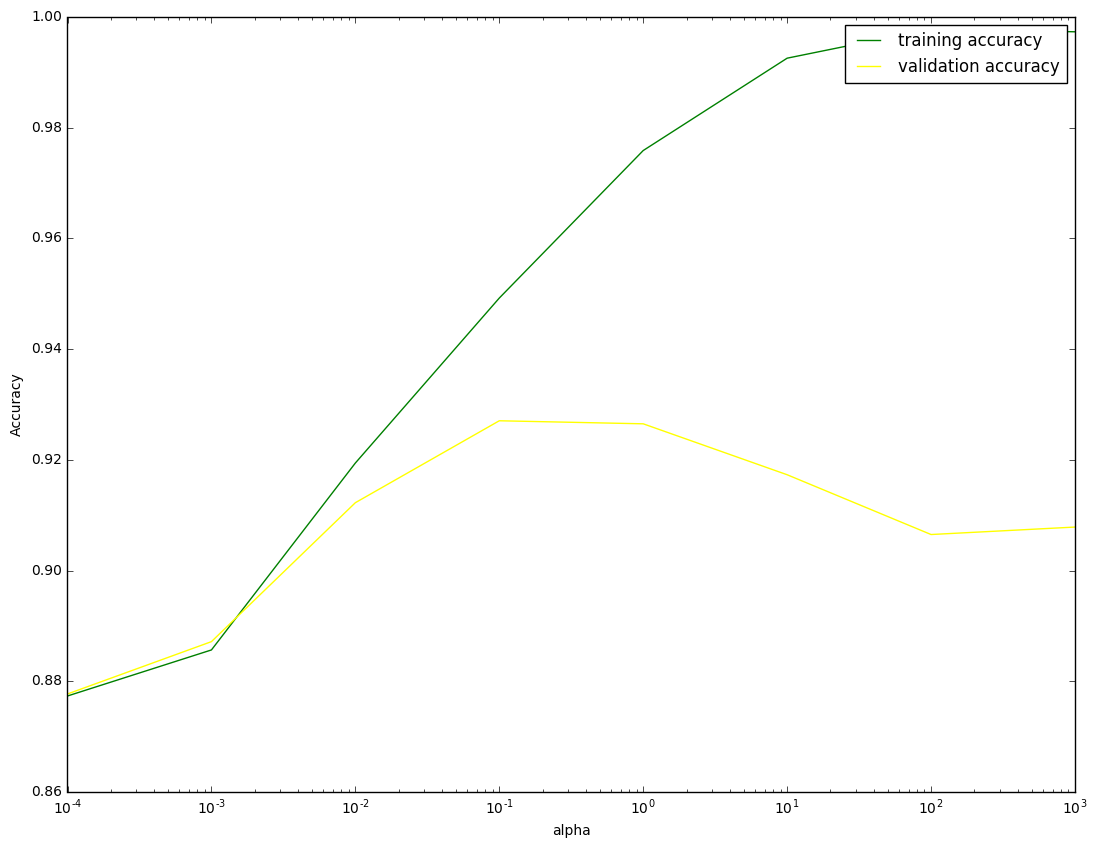

In [52]:
import pylab
plt.figure(figsize=(13, 10))
neighbors_settings = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
plt.plot(neighbors_settings, bow_lgr_train_score_list, label="training accuracy", color='green')
plt.plot(neighbors_settings, bow_lgr_val_score_list, label="validation accuracy", color='yellow')
# plt.plot(neighbors_settings, auc_test, label="test accuracy", color='red')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()
plt.xscale('log')

plt.show()

In [53]:
bow_lgr=LogisticRegression(C=best_c)
bow_lgr.fit(BoW_dict['X_train_vect'],Y_train)
bow_test_proba = bow_lgr.predict_proba(BoW_dict['X_test_vect'])
bow_train_proba = bow_lgr.predict_proba(BoW_dict['X_train_vect'])
bow_test_proba

array([[ 0.08737737,  0.91262263],
       [ 0.38153363,  0.61846637],
       [ 0.17487679,  0.82512321],
       ..., 
       [ 0.0309706 ,  0.9690294 ],
       [ 0.08794723,  0.91205277],
       [ 0.00357721,  0.99642279]])

In [54]:
bow_fpr_train, bow_tpr_train, _ = roc_curve(Y_train, bow_train_proba[:, 1])
bow_fpr_test, bow_tpr_test, _ = roc_curve(Y_test, bow_test_proba[:, 1])
bow_test_auc = auc(bow_fpr_test, bow_tpr_test)
bow_train_auc = auc(bow_fpr_train, bow_tpr_train)
print(bow_test_auc)
print(bow_train_auc)

0.934833965798
0.973719198339


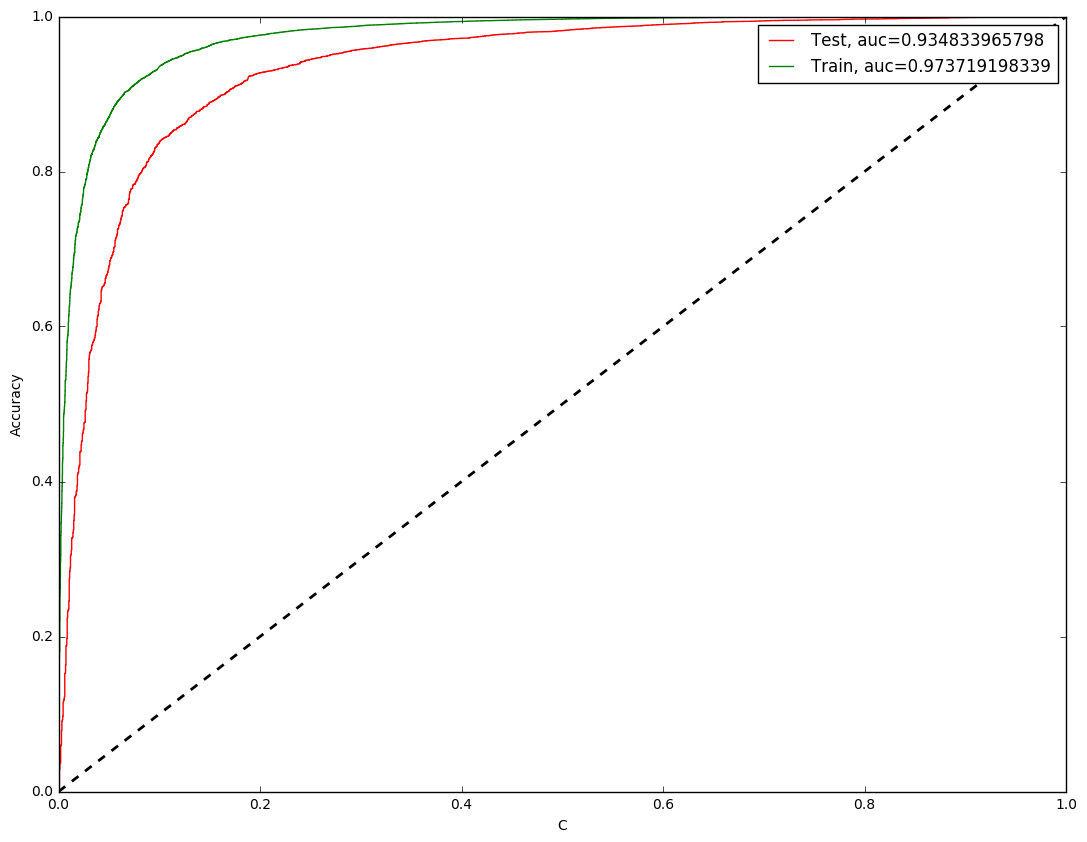

In [55]:
import pylab
plt.figure(figsize=(13, 10))
plt.plot([0,1], [0,1], color='black', lw=2, linestyle='--')
plt.plot(bow_fpr_test, bow_tpr_test, label="Test, auc="+str(bow_test_auc), color = 'red')
plt.plot(bow_fpr_train, bow_tpr_train, label="Train, auc="+str(bow_train_auc), color = 'green')

plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [56]:
#https://stackoverflow.com/questions/26976362/how-to-get-most-informative-features-for-scikit-learn-classifier-for-different-c
neg_features_labels = []
neg_features_coeff = []
neg_features_feat = []

pos_features_labels = []
pos_features_coeff = []
pos_features_feat = []
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=10):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    for coef, feat in topn_class1:
        neg_features_labels.append(class_labels[0])
        neg_features_coeff.append(coef)
        neg_features_feat.append(feat)
    
    for coef, feat in reversed(topn_class2):
        pos_features_labels.append(class_labels[1])
        pos_features_coeff.append(coef)
        pos_features_feat.append(feat)
        
    neg_df = pd.DataFrame({'Labels': neg_features_labels,'Coeff':neg_features_coeff ,'Negative features':neg_features_feat})
    pos_df = pd.DataFrame({'Labels': pos_features_labels,'Coeff':pos_features_coeff ,'Positive features':pos_features_feat})
    print("Top 10 featues for negative class \n", neg_df)
    print("Top 10 featues for positive class \n", pos_df)
    
f = most_informative_feature_for_binary_classification(count_vect, bow_lgr)

Top 10 featues for negative class 
       Coeff  Labels Negative features
0 -2.114204       0             worst
1 -1.770076       0     disappointing
2 -1.584525       0          terrible
3 -1.490974       0             awful
4 -1.400915       0             threw
5 -1.392926       0          horrible
6 -1.367165       0    disappointment
7 -1.222281       0      disappointed
8 -1.188817       0     unfortunately
9 -1.167829       0             bland
Top 10 featues for positive class 
       Coeff  Labels Negative features
0  1.496309       1         delicious
1  1.298627       1         wonderful
2  1.269836       1           perfect
3  1.256619       1             loves
4  1.245180       1           amazing
5  1.235800       1         excellent
6  1.196965       1            highly
7  1.185107       1              best
8  1.176295       1             great
9  1.150668       1           pleased


In [57]:
bow_test_conf = bow_lgr.predict(BoW_dict['X_test_vect'])

In [58]:
from sklearn.metrics import classification_report, confusion_matrix
bow_test_conf_matrix = confusion_matrix(Y_test, bow_test_conf)
class_report = classification_report(Y_test, bow_test_conf)
print(bow_test_conf_matrix)
print(class_report)

[[ 1321  1144]
 [  357 17178]]
             precision    recall  f1-score   support

          0       0.79      0.54      0.64      2465
          1       0.94      0.98      0.96     17535

avg / total       0.92      0.92      0.92     20000



[<matplotlib.text.Text at 0x527a3748>, <matplotlib.text.Text at 0x52e38ef0>]

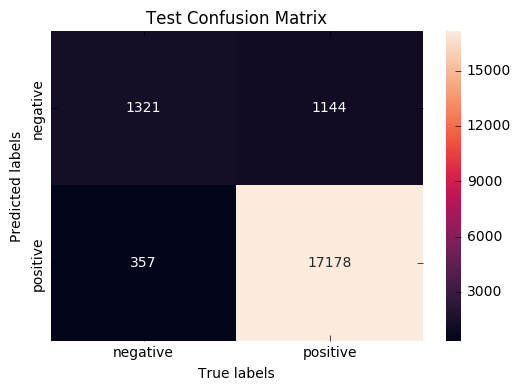

In [59]:
ax= plt.subplot()
sns.heatmap(bow_test_conf_matrix, annot=True, ax = ax, fmt='g')

ax.set_ylabel('Predicted labels')
ax.set_xlabel('True labels')
ax.set_title('Test Confusion Matrix') 
ax.xaxis.set_ticklabels(['negative', 'positive']) 
ax.yaxis.set_ticklabels(['negative', 'positive'])

# Logistic Regression on TF-IDF

In [61]:
import pickle
with open(r"tf_idf.pkl", "rb") as input_file:
    tfidf_dict = pickle.load(input_file)

In [70]:
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

tfidf_lgr_train_score_list = []
tfidf_lgr_val_score_list = []
for c_value in tqdm([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]):
    tfidf_lgr=LogisticRegression(C=c_value)
    tfidf_lgr.fit(tfidf_dict['train_tf_idf'],Y_train)
    
    tfidf_lgr_train_score = tfidf_lgr.score(tfidf_dict['train_tf_idf'], Y_train)
    tfidf_lgr_train_score_list.append(tfidf_lgr_train_score)
    tfidf_lgr_val_score = tfidf_lgr.score(tfidf_dict['cv_tf_idf'], Y_val)
    tfidf_lgr_val_score_list.append(tfidf_lgr_val_score)

c_all = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
tfidf_train_score = dict(zip(c_all, tfidf_lgr_train_score_list))
tfidf_val_score = dict(zip(c_all, tfidf_lgr_val_score_list))
print(tfidf_train_score)
print(tfidf_val_score)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:07<00:00,  1.01it/s]


{0.1: 0.88736666666666664, 1: 0.94546666666666668, 100: 0.99960000000000004, 1000: 0.99963333333333337, 0.0001: 0.8773333333333333, 10: 0.98733333333333329, 0.01: 0.8773333333333333, 0.001: 0.8773333333333333}
{0.1: 0.88770000000000004, 1: 0.92910000000000004, 100: 0.93625000000000003, 1000: 0.93300000000000005, 0.0001: 0.87770000000000004, 10: 0.94025000000000003, 0.01: 0.87770000000000004, 0.001: 0.87770000000000004}


In [71]:
tfidf_best_c = max(tfidf_val_score, key=tfidf_val_score.get)
tfidf_best_c

10

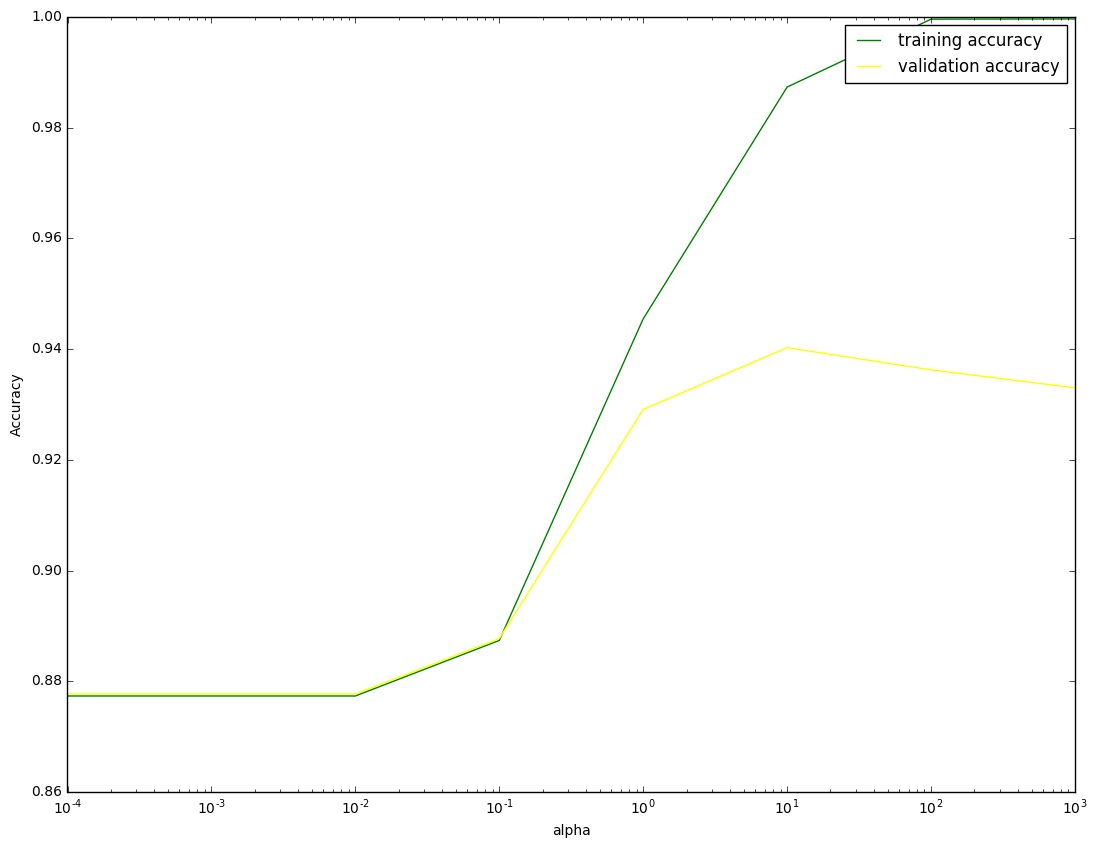

In [72]:
import pylab
plt.figure(figsize=(13, 10))
neighbors_settings = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
plt.plot(neighbors_settings, tfidf_lgr_train_score_list, label="training accuracy", color='green')
plt.plot(neighbors_settings, tfidf_lgr_val_score_list, label="validation accuracy", color='yellow')
# plt.plot(neighbors_settings, auc_test, label="test accuracy", color='red')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()
plt.xscale('log')

plt.show()

In [73]:
#https://stackoverflow.com/questions/26976362/how-to-get-most-informative-features-for-scikit-learn-classifier-for-different-c
neg_features_labels = []
neg_features_coeff = []
neg_features_feat = []

pos_features_labels = []
pos_features_coeff = []
pos_features_feat = []
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=10):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    for coef, feat in topn_class1:
        neg_features_labels.append(class_labels[0])
        neg_features_coeff.append(coef)
        neg_features_feat.append(feat)
    
    for coef, feat in reversed(topn_class2):
        pos_features_labels.append(class_labels[1])
        pos_features_coeff.append(coef)
        pos_features_feat.append(feat)
        
    neg_df = pd.DataFrame({'Labels': neg_features_labels,'Coeff':neg_features_coeff ,'Negative features':neg_features_feat})
    pos_df = pd.DataFrame({'Labels': pos_features_labels,'Coeff':pos_features_coeff ,'Positive features':pos_features_feat})
    print("Top 10 featues for negative class \n", neg_df)
    print("Top 10 featues for positive class \n", pos_df)
    
f = most_informative_feature_for_binary_classification(tf_idf_vect, tfidf_lgr)

Top 10 featues for negative class 
        Coeff  Labels Negative features
0 -39.009614       0         not worth
1 -36.845341       0             worst
2 -35.496276       0         two stars
3 -31.723485       0     disappointing
4 -30.467210       0      disappointed
5 -27.881993       0     not recommend
6 -26.579318       0             threw
7 -26.543288       0             awful
8 -25.979292       0    disappointment
9 -24.209722       0          terrible
Top 10 featues for positive class 
        Coeff  Labels Positive features
0  42.071481       1             great
1  40.822195       1  not disappointed
2  36.981985       1         delicious
3  30.704022       1              good
4  30.542061       1              best
5  30.018440       1         wonderful
6  27.833478       1           pleased
7  27.550736       1             loves
8  26.585556       1           perfect
9  26.149026       1         excellent


In [75]:
tfidf_lgr=LogisticRegression(C=tfidf_best_c)
tfidf_lgr.fit(tfidf_dict['train_tf_idf'], Y_train)
tfidf_test_proba = tfidf_lgr.predict_proba(tfidf_dict['test_tf_idf'])
tfidf_train_proba = tfidf_lgr.predict_proba(tfidf_dict['train_tf_idf'])
tfidf_test_proba

array([[  1.76158483e-02,   9.82384152e-01],
       [  2.31736575e-01,   7.68263425e-01],
       [  9.17723208e-02,   9.08227679e-01],
       ..., 
       [  7.49455319e-04,   9.99250545e-01],
       [  1.09176014e-02,   9.89082399e-01],
       [  3.41090904e-04,   9.99658909e-01]])

In [76]:
tfidf_fpr_train, tfidf_tpr_train, _ = roc_curve(Y_train, tfidf_train_proba[:, 1])
tfidf_fpr_test, tfidf_tpr_test, _ = roc_curve(Y_test, tfidf_test_proba[:, 1])
tfidf_test_auc = auc(tfidf_fpr_test, tfidf_tpr_test)
tfidf_train_auc = auc(tfidf_fpr_train, tfidf_tpr_train)
print(tfidf_test_auc)
print(tfidf_train_auc)

0.957725834914
0.998499669876


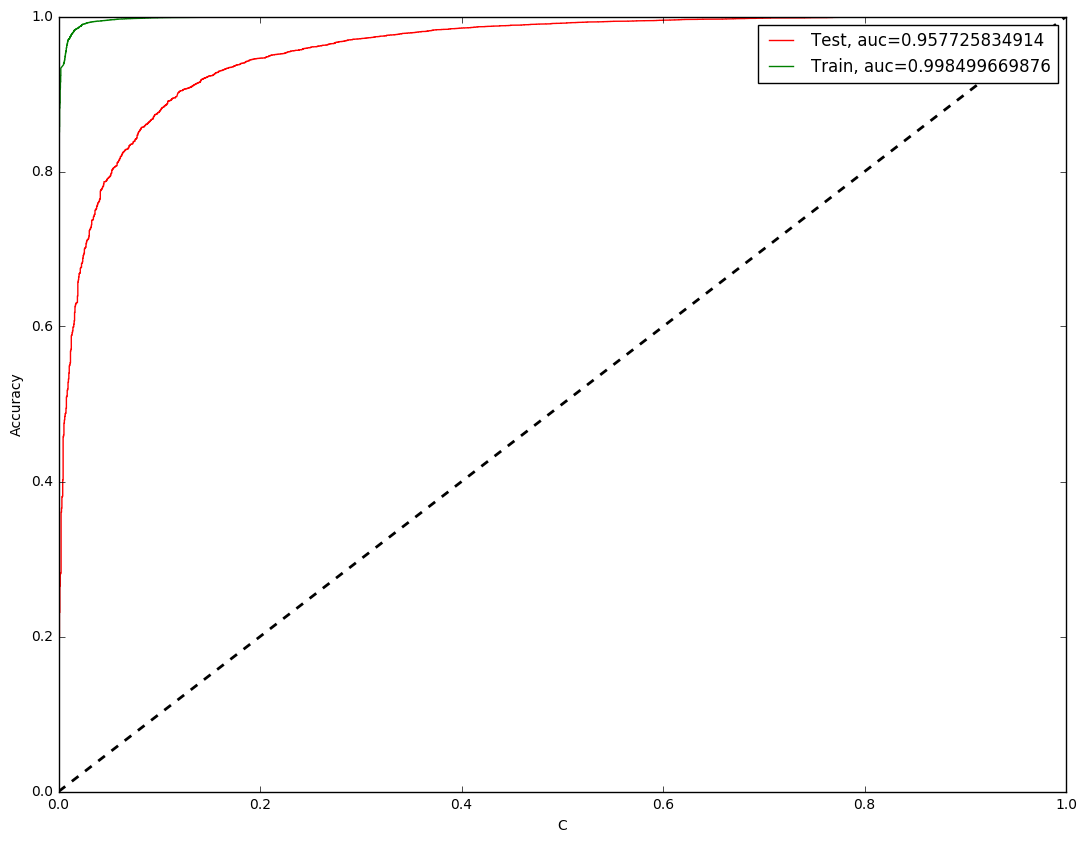

In [77]:
import pylab
plt.figure(figsize=(13, 10))
plt.plot([0,1], [0,1], color='black', lw=2, linestyle='--')
plt.plot(tfidf_fpr_test, tfidf_tpr_test, label="Test, auc="+str(tfidf_test_auc), color = 'red')
plt.plot(tfidf_fpr_train, tfidf_tpr_train, label="Train, auc="+str(tfidf_train_auc), color = 'green')

plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()

plt.show()